In [13]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [14]:
import numpy as np
import re
from numpy import linalg as LA
from time import time
from scipy import sparse
import matplotlib.pyplot as plt

In [15]:
N=100
kx=np.linspace(0,np.pi,N)
ky=np.linspace(0,np.pi,N)
plt.rcParams['figure.figsize'] = [7,7]
Kx,Ky=np.meshgrid(kx,ky)
E=-2*(np.cos(Kx)+np.cos(Ky))
E_F=-3.8
CS=plt.contour(kx,ky,E,levels=[E_F],color='red')
#plt.contour(-kx,ky,E,levels=[E_F],color='red')
#plt.contour(-kx,-ky,E,levels=[E_F],color='red')
#plt.contour(kx,-ky,E,levels=[E_F],color='red')
#plt.contourf(kx,ky,E,cmap='Blues')
#plt.contourf(-kx,ky,E,cmap='Blues')
#plt.contourf(-kx,-ky,E,cmap='Blues')
#plt.contourf(kx,-ky,E,cmap='Blues')
F = CS.collections[0].get_paths()[0]
plt.close()
coordsF = F.vertices
vF = np.dstack([2*np.sin(coordsF[:,0]),2*np.sin(coordsF[:,1])])[0]
vFmag = vF[:,0]*vF[:,0]+vF[:,1]*vF[:,1]
shatF  = vF/np.transpose([vFmag])
thetaF0 =  np.float64(np.arctan((vF[:,1]+1e-2)/(vF[:,0]+1e-2))) 
coordsFx_irr = coordsF[:,0]
coordsFy_irr = coordsF[:,1]
Lambda0=np.pi/(2*np.sqrt(2))
steps=30000 #30000
eps=(1-1/(N*N)) #0.9999
lambdaF=Lambda0*eps**np.linspace(0,steps-1,steps)
ThetaF,LambdaF=np.meshgrid(thetaF0,lambdaF)
Fwvfx_out = coordsFx_irr+LambdaF*np.cos(ThetaF)
Fwvfy_out = coordsFy_irr+LambdaF*np.sin(ThetaF)
EFwvf=-2*(np.cos(Fwvfx_out)+np.cos(Fwvfy_out))

In [16]:
EFwvfAvg=np.sum(EFwvf,axis=1)/len(thetaF0)

In [17]:
EFwvfAvg

array([-1.90793625, -1.9081885 , -1.90844072, ..., -3.7488182 ,
       -3.74882362, -3.74882903])

In [18]:
J0=1/(N*N)#1.19e9/(N*N)#5e-3/(N*N)
J=np.zeros(steps)
J[0]=J0
omega=4 #1/2 of bandwidth in 2D

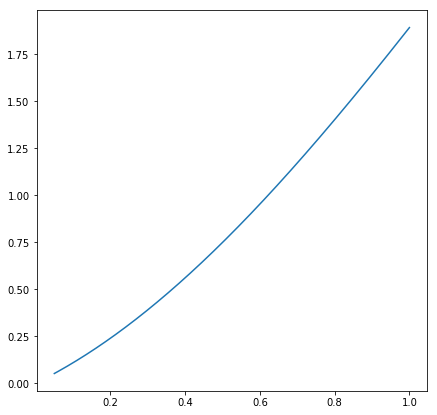

In [19]:
plt.plot(lambdaF/Lambda0,EFwvfAvg-E_F)

In [20]:
k=0
for i in range(len(lambdaF)-1):
    Ek=EFwvfAvg[i]-E_F
    if(Ek-J[0]/4>0):
        if(Ek-J[i]/4>0):

            J[i+1]=J[i]+2*np.pi*np.sqrt(0.2)*J[i]*(1/((Ek)**2-J[i]**2/16))*J[i]*(Ek)
        else:
            J[i:]=4*Ek
            k=i
            break
    else:
        if(Ek-J[i]/4<0):

            J[i+1]=J[i]+2*np.pi*np.sqrt(0.2)*J[i]*(1/((Ek)**2-J[i]**2/16))*J[i]*(Ek)
        else:
            J[i:]=4*Ek
            k=i
            break
    

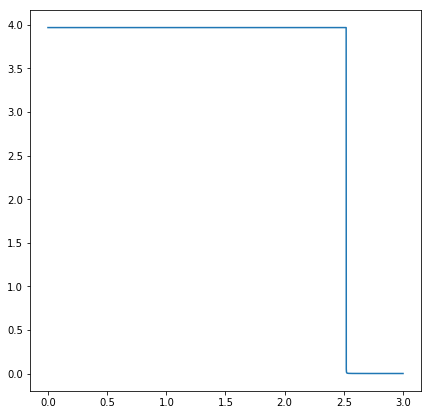

In [21]:
plt.plot(-np.log(lambdaF/Lambda0),J[::-1])

Let us write the Kondo Singlet wavefunction in terms of four electronic states near Fermi surface $|k_{F},\uparrow\rangle$, $|k_{F},\downarrow\rangle$,$|k_{F}+\delta,\uparrow\rangle$,$|k_{F}+\delta,\downarrow\rangle$ that are coupled to the Kondo impurity configurations $|\Uparrow\rangle$ $|\Downarrow\rangle$ respectively. Additionally at wave-vector $|k_{F}+2\delta,\uparrow\rangle$, $|k_{F}+2\delta,\downarrow\rangle$ we place another electronic state in the occupied configuration representing the local Fermi liquid. <br>
$|\Psi\rangle = \frac{1}{\sqrt{2}}\left[\sum_{j=0}^{1}|\Uparrow 1_{k_{F}+j\delta,\downarrow}\rangle| \text{other states}\rangle-\sum_{j=0}^{1}|\Downarrow 1_{k_{F}+j\delta,\uparrow}\rangle| \text{other states}\rangle\right]$ 

In [22]:
labelSites='I112233445566'
labelSpins=' 010101010101'
conf0='1100010000000'
conf1='0010010000000'
conf2='1001010000000'
conf3='0000110000000'
weights=[0.5,-0.5,0.5,-0.5]
f=open('KondoWvFn0.txt','+w')
f.write(labelSites+'\n')
f.write(labelSpins+'\n')
f.write(conf0+str(weights[0])+'\n')
f.write(conf1+str(weights[1])+'\n')
f.write(conf2+str(weights[2])+'\n')
f.write(conf3+str(weights[3]))
f.close()

In [23]:
J[4794:4806]

array([0.04490949, 0.05061228, 0.05785655, 0.06732477, 0.08014817,
       0.09832636, 0.12569486, 0.17044278, 0.2528032 , 0.43441638,
       0.97506934, 3.83940447])

In [24]:
from tqdm import tqdm
invG=(EFwvfAvg[4794:4806]-E_F)[::-1]*0.5
Jarr=J[4794:4806][::-1]
N=13
list1=np.array([i+1 for i in range(12)],dtype=np.int)
def reverseRG(Psi,j):
    Ket=np.array([np.array([conf[:N],conf[N:]]) for conf in Psi[2:]])
    PsiOld=np.rec.fromarrays([Ket[:,0],Ket[:,1].astype(np.float64)],names='keys,vals')
    iom=j+4
    if(iom<13):
        print(iom)
        ents=list1[0:iom]
        PsiNew = np.rec.fromarrays([np.zeros(len(PsiOld)*(4*j+5),dtype='<U32') ,np.zeros(len(PsiOld)*(4*j+5),dtype=np.float32)], names='keys,vals')
        #putting old confs into new conf
        Nold=len(PsiOld)
        PsiNew['keys'][0:Nold]=PsiOld['keys']
        PsiNew['vals'][0:Nold]=PsiOld['vals']
        checkConf=lambda conf,iom,ent:1 if conf[ent]==conf[iom] else 0
        confEig=lambda conf:-1 if conf=='0' else 1
        mod=lambda conf:'0' if conf=='1' else '1'
        process=lambda conf,a,b:conf[0:a]+conf[b]+conf[a+1:b]+conf[a]+conf[b+1:] if (a+b)%2==0 else mod(conf[0])+conf[1:a]+conf[b]+conf[a+1:b]+conf[a]+conf[b+1:] 
        exchangeString=lambda a,b: (-1)**(a-b)
        weight=lambda conf,iom,ent,j:exchangeString(iom,ent)*(invG[iom]*confEig(conf[iom])-Jarr[j]*0.25*confEig(conf[iom])*confEig(conf[0]))**(-1)*Jarr[j]
        supCoeffForConf= lambda w,Nold,PsiNew,modConf:w+PsiNew[0:Nold][np.where(PsiNew[0:Nold]['keys']==modConf)]['vals'] if modConf in PsiNew[0:Nold]['keys'] else w
        indFun=lambda modConf,PsiNew,Nold:np.where(PsiNew['keys'][0:Nold]==modConf)[0][0] if modConf in PsiNew[0:Nold]['keys'] else Nold
        for conf in tqdm(PsiOld):
            for i in range(len(ents)):
                if checkConf(conf['keys'],iom, ents[i])==0:
                    modConf=process(conf['keys'],ents[i],iom)
                    w=weight(conf['keys'],iom,ents[i],j)
                    coeff=supCoeffForConf(w,Nold,PsiNew,modConf)
                    ind=indFun(modConf,PsiNew,Nold)
                    PsiNew['vals'][ind]=coeff
                    PsiNew['keys'][ind]=modConf
                    Nold=Nold if ind!=Nold else Nold+1
        PsiNew['vals']=PsiNew['vals']/np.sqrt(np.sum(PsiNew['vals']*PsiNew['vals']))
        PsiNew=PsiNew[PsiNew['vals']!=0.0]
        return PsiNew[PsiNew['keys']!='']
    else:
        print('No decoupled electrons left to be entangled')

In [25]:
Psi=open("KondoWvFn0.txt","+r").readlines()
Tpsi=reverseRG(Psi,1)
print(Tpsi)
PsiN=open("KondoWvFn1.txt","+w")
PsiWrite = labelSites+'\n'+labelSpins+'\n'+''.join([conf['keys']+str(conf['vals'])+'\n' for conf in Tpsi])
PsiN.write(PsiWrite)
PsiN.close()

100%|██████████| 4/4 [00:00<00:00, 1132.07it/s]

5
[('1100010000000',  0.05177316) ('0010010000000', -0.05177316)
 ('1001010000000',  0.05177316) ('0000110000000', -0.05177316)
 ('0110000000000', -0.26303467) ('1101000000000',  0.7988307 )
 ('0100100000000', -0.26303467) ('0011000000000', -0.26303467)
 ('1010100000000', -0.27276137) ('0001100000000', -0.26303467)]


In [26]:
Psi=open("KondoWvFn1.txt","+r").readlines()
print(Psi)
Tpsi=reverseRG(Psi,2)
print(Tpsi)
PsiN=open("KondoWvFn2.txt","+w")
PsiWrite = labelSites+'\n'+labelSpins+'\n'+''.join([conf['keys']+str(conf['vals'])+'\n' for conf in Tpsi])
PsiN.write(PsiWrite)
PsiN.close()

100%|██████████| 10/10 [00:00<00:00, 1483.34it/s]

['I112233445566\n', ' 010101010101\n', '11000100000000.05177316\n', '0010010000000-0.05177316\n', '10010100000000.05177316\n', '0000110000000-0.05177316\n', '0110000000000-0.26303467\n', '11010000000000.7988307\n', '0100100000000-0.26303467\n', '0011000000000-0.26303467\n', '1010100000000-0.27276137\n', '0001100000000-0.26303467\n']
6
[('1100010000000',  0.02298251) ('0010010000000', -0.02298251)
 ('1001010000000',  0.02298251) ('0000110000000', -0.02298251)
 ('0110000000000', -0.11676317) ('1101000000000',  0.35460722)
 ('0100100000000', -0.11676317) ('0011000000000', -0.11676317)
 ('1010100000000', -0.12108092) ('0001100000000', -0.11676317)
 ('0000011000000',  0.35673714) ('0100001000000',  0.35673714)
 ('1010001000000',  0.4588908 ) ('0001001000000',  0.35673714)
 ('1000101000000',  0.45889086)]


In [27]:
Psi=open("KondoWvFn2.txt","+r").readlines()
print(Psi)
Tpsi=reverseRG(Psi,3)
print(Tpsi)
PsiN=open("KondoWvFn3.txt","+w")
PsiWrite = labelSites+'\n'+labelSpins+'\n'+''.join([conf['keys']+str(conf['vals'])+'\n' for conf in Tpsi])
PsiN.write(PsiWrite)
PsiN.close()

100%|██████████| 15/15 [00:00<00:00, 1328.88it/s]

['I112233445566\n', ' 010101010101\n', '11000100000000.022982514\n', '0010010000000-0.022982514\n', '10010100000000.022982514\n', '0000110000000-0.022982514\n', '0110000000000-0.11676317\n', '11010000000000.35460722\n', '0100100000000-0.11676317\n', '0011000000000-0.11676317\n', '1010100000000-0.12108092\n', '0001100000000-0.11676317\n', '00000110000000.35673714\n', '01000010000000.35673714\n', '10100010000000.4588908\n', '00010010000000.35673714\n', '10001010000000.45889086\n']
7
[('1100010000000',  0.02087151) ('0010010000000', -0.02087151)
 ('1001010000000',  0.02087151) ('0000110000000', -0.02087151)
 ('0110000000000', -0.10603814) ('1101000000000',  0.32203555)
 ('0100100000000', -0.10603814) ('0011000000000', -0.10603814)
 ('1010100000000', -0.1099593 ) ('0001100000000', -0.10603814)
 ('0000011000000',  0.3239698 ) ('0100001000000',  0.3239698 )
 ('1010001000000',  0.4167404 ) ('0001001000000',  0.3239698 )
 ('1000101000000',  0.41674042) ('1000010100000',  0.17091356)
 ('1100000

In [28]:
Psi=open("KondoWvFn3.txt","+r").readlines()
Tpsi=reverseRG(Psi,4)
print(Tpsi)
PsiN=open("KondoWvFn4.txt","+w")
PsiWrite = labelSites+'\n'+labelSpins+'\n'+''.join([conf['keys']+str(conf['vals'])+'\n' for conf in Tpsi])
PsiN.write(PsiWrite)
PsiN.close()

100%|██████████| 21/21 [00:00<00:00, 1355.52it/s]

8
[('1100010000000',  0.01507295) ('0010010000000', -0.01507295)
 ('1001010000000',  0.01507295) ('0000110000000', -0.01507295)
 ('0110000000000', -0.07657845) ('1101000000000',  0.23256709)
 ('0100100000000', -0.07657845) ('0011000000000', -0.07657845)
 ('1010100000000', -0.07941022) ('0001100000000', -0.07657845)
 ('0000011000000',  0.23396397) ('0100001000000',  0.23396397)
 ('1010001000000',  0.30096087) ('0001001000000',  0.23396397)
 ('1000101000000',  0.3009609 ) ('1000010100000',  0.12343007)
 ('1100000100000',  0.12343007) ('0010000100000', -0.12343011)
 ('1001000100000',  0.12343007) ('0000100100000', -0.12343007)
 ('0000001100000', -0.12343007) ('0000010010000',  0.12847786)
 ('0100000010000',  0.12847786) ('1010000010000',  0.37077948)
 ('0001000010000',  0.12847786) ('1000100010000',  0.37077948)
 ('1000001010000',  0.37077948) ('0000000110000',  0.12847786)]


In [29]:
Psi=open("KondoWvFn4.txt","+r").readlines()
print(Psi)
Tpsi=reverseRG(Psi,5)
print(Tpsi)
PsiN=open("KondoWvFn5.txt","+w")
PsiWrite = labelSites+'\n'+labelSpins+'\n'+''.join([conf['keys']+str(conf['vals'])+'\n' for conf in Tpsi])
PsiN.write(PsiWrite)
PsiN.close()

100%|██████████| 28/28 [00:00<00:00, 1402.48it/s]

['I112233445566\n', ' 010101010101\n', '11000100000000.015072948\n', '0010010000000-0.015072948\n', '10010100000000.015072948\n', '0000110000000-0.015072948\n', '0110000000000-0.076578446\n', '11010000000000.23256709\n', '0100100000000-0.076578446\n', '0011000000000-0.076578446\n', '1010100000000-0.07941022\n', '0001100000000-0.076578446\n', '00000110000000.23396397\n', '01000010000000.23396397\n', '10100010000000.30096087\n', '00010010000000.23396397\n', '10001010000000.3009609\n', '10000101000000.123430066\n', '11000001000000.123430066\n', '0010000100000-0.12343011\n', '10010001000000.123430066\n', '0000100100000-0.123430066\n', '0000001100000-0.123430066\n', '00000100100000.12847786\n', '01000000100000.12847786\n', '10100000100000.37077948\n', '00010000100000.12847786\n', '10001000100000.37077948\n', '10000010100000.37077948\n', '00000001100000.12847786\n']
9
[('1100010000000',  0.01399311) ('0010010000000', -0.01399311)
 ('1001010000000',  0.01399311) ('0000110000000', -0.01399311)

In [30]:
Psi=open("KondoWvFn5.txt","+r").readlines()
Tpsi=reverseRG(Psi,6)
PsiN=open("KondoWvFn6.txt","+w")
PsiWrite = labelSites+'\n'+labelSpins+'\n'+''.join([conf['keys']+str(conf['vals'])+'\n' for conf in Tpsi])
PsiN.write(PsiWrite)
PsiN.close()

100%|██████████| 36/36 [00:00<00:00, 1388.09it/s]

10


In [31]:
Psi=open("KondoWvFn6.txt","+r").readlines()
Tpsi=reverseRG(Psi,7)
PsiN=open("KondoWvFn7.txt","+w")
PsiWrite = labelSites+'\n'+labelSpins+'\n'+''.join([conf['keys']+str(conf['vals'])+'\n' for conf in Tpsi])
PsiN.write(PsiWrite)
PsiN.close()

100%|██████████| 45/45 [00:00<00:00, 1441.26it/s]

11


  0%|          | 0/55 [00:00<?, ?it/s]

12


IndexError: index 12 is out of bounds for axis 0 with size 12